In [211]:
from dotenv import load_dotenv
import os
load_dotenv()
API_KEY = os.environ.get("API_KEY")
SECRET_KEY = os.environ.get("SECRET_KEY")


In [212]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [213]:

# Create the client
client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# Define date range
end_date = datetime.now()
start_date = end_date - timedelta(days= 252)  

# Create request for NVDA
request = StockBarsRequest(
    symbol_or_symbols=["NVDA", "AMD"],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date
)


# Fetch data
bars = client.get_stock_bars(request)

# # Convert to DataFrames
df = bars.df.reset_index()
df = df.pivot(index="timestamp", columns="symbol", values="close")
print(df)


symbol                        AMD    NVDA
timestamp                                
2024-12-06 05:00:00+00:00  138.59  142.44
2024-12-09 05:00:00+00:00  130.87  138.81
2024-12-10 05:00:00+00:00  127.74  135.07
2024-12-11 05:00:00+00:00  130.15  139.31
2024-12-12 05:00:00+00:00  130.60  137.34
...                           ...     ...
2025-08-08 04:00:00+00:00  172.76  182.70
2025-08-11 04:00:00+00:00  172.28  182.06
2025-08-12 04:00:00+00:00  174.95  183.16
2025-08-13 04:00:00+00:00  184.42  181.59
2025-08-14 04:00:00+00:00  180.95  182.02

[171 rows x 2 columns]


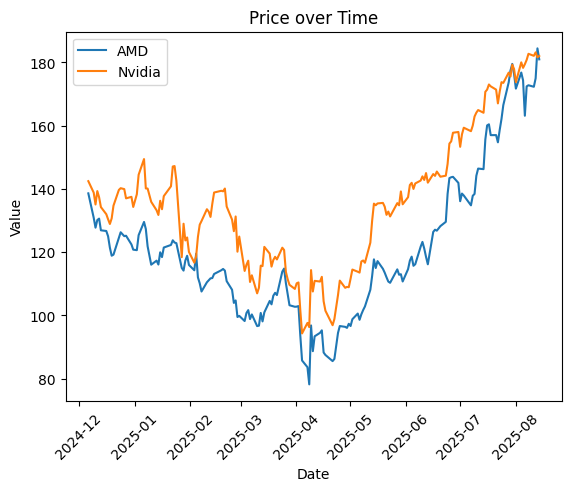

In [214]:
plt.plot(df.index, df['AMD'], label='AMD')
plt.plot(df.index, df['NVDA'], label='Nvidia')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Price over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [215]:
print(df.corr())

symbol       AMD      NVDA
symbol                    
AMD     1.000000  0.958641
NVDA    0.958641  1.000000


In [216]:
# Since assets can be highly correlated and still diverge, we will use a stronger statistical measure, called cointegration
import statsmodels.tsa.stattools as ts 
result = ts.coint(df['AMD'], df['NVDA'])
p_val = result[1]
if p_val < 0.05:
    print(f"With a p value of {round(p_val,4)}, we can reject the null hypothesis and conclude the assets are cointegrated.")
else:
    print(f"With a p value of {round(p_val,4)}, we cannot reject the null hypothesis and conclude the assets are not cointegrated.")



With a p value of 0.0259, we can reject the null hypothesis and conclude the assets are cointegrated.


In [217]:
# Next we will calculate the spread using OLS
import statsmodels.api as sm
# Step 1: Define dependent and independent variables
Y = df['NVDA']
X = df['AMD']

# Step 2: Add constant term for regression
X = sm.add_constant(X)

# Step 3: Run OLS regression
model = sm.OLS(Y, X).fit()

# Step 4: Hedge ratio is the slope (coefficient on AMD)
hedge_ratio = model.params['AMD']

print(f"Hedge Ratio: {hedge_ratio}")

# Step 5: Compute the spread
spread = df['NVDA'] - hedge_ratio * df['AMD']


Hedge Ratio: 0.9006486702335255


In [218]:
# In order to work with means that aren't meaningless, we must determine whether our spread is stationary or not
from statsmodels.tsa.stattools import adfuller

result = adfuller(spread)
p_val = result[1]
if p_val < 0.05:
    print(f"With a p value of {round(p_val,4)}, we can reject the null hypothesis and conclude the spread is likely stationary.")
else:
    print(f"With a p value of {round(p_val,4)}, we cannot reject the null hypothesis and conclude the spread is likely not stationary.")


With a p value of 0.0035, we can reject the null hypothesis and conclude the spread is likely stationary.


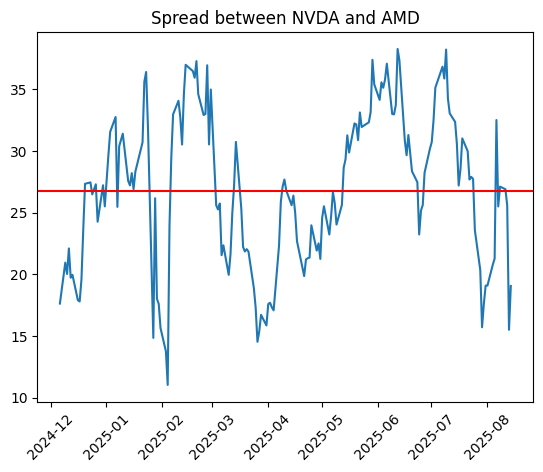

In [219]:

plt.plot(df.index, spread, label = 'Spread (NVDA - AMD)')
plt.axhline(spread.mean(), color='red')
plt.title("Spread between NVDA and AMD")
plt.xticks(rotation=45)
plt.show()

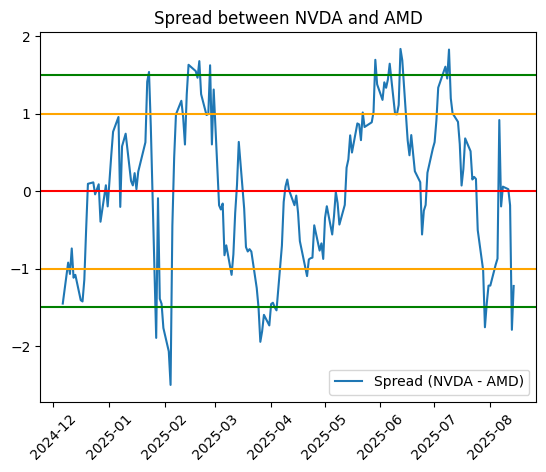

In [220]:
# Next, we will standardize the spread so that the mean is 0 and the standard deviation is 1
# As we can see, if the spread deviates past 1 standard deviation from the mean, it is likely to soon revert back to the mean
spread_normalized = (spread - spread.mean()) / spread.std()
plt.plot(df.index, spread_normalized, label = 'Spread (NVDA - AMD)')
plt.axhline(1, color='orange')
plt.axhline(1.5, color='green')

plt.axhline(0, color='red')
plt.axhline(-1, color='orange')
plt.axhline(-1.5, color='green')
plt.title("Spread between NVDA and AMD")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
#smooth the spread over last 3 days average
spread_5_mean = spread.rolling(3).mean()
#since we can't know the future means and stds, we will use the last 60 days
spread_60_mean = spread.rolling(60).mean()
spread_60_std = spread.rolling(60).std()
# z_score_60_5 = (spread_5_mean - spread_60_mean) / spread_60_std
z_score_60_5 = (spread_5_mean - spread_60_mean) / spread_60_std

z_score_raw = (spread - spread_60_mean) / spread_60_std



# plt.plot(df.index, z_score_60_5, label = 'Spread Rolling')
# plt.plot(df.index, spread_normalized, label = 'Spread All')
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

                           zscore_smoothed  zscore_raw  longs  shorts  \
timestamp                                                               
2025-03-06 05:00:00+00:00        -0.427075   -0.820613  False   False   
2025-03-07 05:00:00+00:00        -0.591064   -0.721270  False   False   
2025-03-10 04:00:00+00:00        -0.878043   -1.078696  False   False   
2025-03-11 04:00:00+00:00        -0.881828   -0.834821  False   False   
2025-03-12 04:00:00+00:00        -0.759889   -0.335526  False   False   
...                                    ...         ...    ...     ...   
2025-08-08 04:00:00+00:00        -0.315549   -0.550666  False   False   
2025-08-11 04:00:00+00:00        -0.653687   -0.580168  False   False   
2025-08-12 04:00:00+00:00        -0.627199   -0.800303  False   False   
2025-08-13 04:00:00+00:00        -1.226121   -2.475671  False   False   
2025-08-14 04:00:00+00:00        -1.601568   -1.770766   True   False   

                           long_exit_candidate  sh

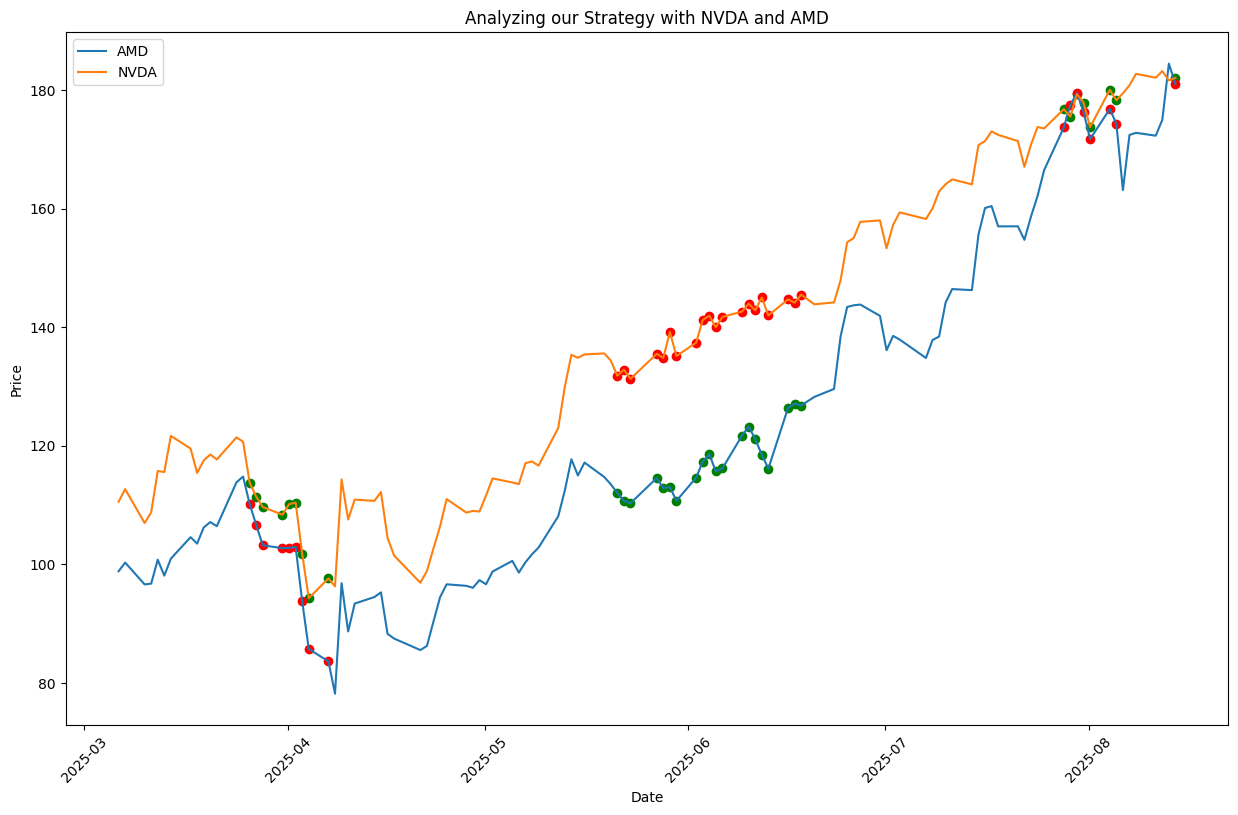

In [222]:
z_score_5 = pd.DataFrame(z_score_60_5, columns=['zscore_smoothed'])
z_score_raw = pd.DataFrame(z_score_raw, columns=['zscore_raw'])

# trades = pd.concat([z_score_5, z_score_raw], axis=1)
trades = pd.merge(z_score_5, z_score_raw, left_index=True, right_index=True)
trades = trades[trades['zscore_smoothed'].notnull()]

upper_band = 1.5
lower_band = -1.5
exit_band = 0.3
# spread = pd.DataFrame(spread, columns=['spread'])
trades['longs'] = trades['zscore_smoothed'] < lower_band
trades['shorts'] = trades['zscore_smoothed'] > upper_band
# trades['exits'] = abs(trades['zscore']) < exit_band
# Long exit threshold = -0.3 or above
trades['long_exit_candidate'] = trades['zscore_raw'] >= -exit_band

# Short exit threshold = 0.3 or below
trades['short_exit_candidate'] = trades['zscore_raw'] <= exit_band

trades['position'] = 0  # start flat

for i in range(1, len(trades)):
    prev_pos = trades['position'].iat[i-1]  # get previous position by position
    
    if prev_pos == 0:
        # Enter trades
        if trades['longs'].iat[i]:
            trades['position'].iat[i] = 1
        elif trades['shorts'].iat[i]:
            trades['position'].iat[i] = -1
        else:
            trades['position'].iat[i] = 0
    elif prev_pos == 1:
        # Long: exit if candidate is True
        trades['position'].iat[i] = 0 if trades['long_exit_candidate'].iat[i] else 1
    elif prev_pos == -1:
        # Short: exit if candidate is True
        trades['position'].iat[i] = 0 if trades['short_exit_candidate'].iat[i] else -1
print(trades)

# trades['position'] = np.nan
# trades.loc[trades['longs'], 'position'] = 1
# trades.loc[trades['shorts'], 'position'] = -1
# trades.loc[trades['exits'], 'position'] = 0
# trades['position'] = trades['position'].ffill().fillna(0)

# # Long exits: position = 1, zscore >= -0.3
# trades.loc[(trades['position'] == 1) & (trades['zscore'] >= -exit_band), 'exits'] = True

# # Short exits: position = -1, zscore <= 0.3
# trades.loc[(trades['position'] == -1) & (trades['zscore'] <= exit_band), 'exits'] = True

# trades.loc[trades['exits'], 'position'] = 0
# trades['position'] = trades['position'].ffill().fillna(0)

trades['pos_change'] = trades['position'].diff()


# trades.to_csv('trades.csv')

trades = pd.merge(trades, df, how = 'left', left_index=True, right_index=True)

longs = trades[trades['position'] == 1]
shorts = trades[trades['position'] == -1]
# trades = pd.merge(spread, trades, left_index=True, right_index=True)
# trades['spread_ret'] = trades['spread'].diff()
# trades['pnl'] = trades['position'].shift(1) * trades['spread_ret']
# trades['cum_pnl'] = trades['pnl'].cumsum()

plt.figure(figsize=(15,9))
plt.plot(trades.index, trades['AMD'], label='AMD')
plt.plot(trades.index, trades['NVDA'], label='NVDA')

# plt.scatter(longs.index, longs['NVDA'], color='green', marker='^')
# plt.scatter(shorts.index, shorts['NVDA'], color='red', marker='v')
plt.scatter(longs.index, longs['NVDA'], color='green')
plt.scatter(shorts.index, shorts['NVDA'], color='red')

plt.scatter(longs.index, longs['AMD'], color='red')
plt.scatter(shorts.index, shorts['AMD'], color='green')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Analyzing our Strategy with NVDA and AMD')
plt.xticks(rotation=45)
plt.legend()
plt.show()



In [223]:
# plt.figure(figsize=(15,9))
# plt.plot(trades.index, trades['zscore'], label='zscore')

# plt.scatter(longs.index, longs['zscore'], color='green')
# plt.scatter(shorts.index, shorts['zscore'], color='red')

# plt.xlabel('Date')
# plt.ylabel('Z Score')
# plt.title('Analyzing our Strategy with Z Scores')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [224]:
# profits = pd.merge(trades, df, how = 'left', left_index=True, right_index=True)
# print(profits)
profits = trades.copy()
profits['spread'] = profits['NVDA'] - (hedge_ratio * profits['AMD'])

# Spread returns
profits['spread_ret'] = profits['spread'].pct_change()

# Strategy returns
profits['strategy_returns'] = profits['position'].shift(1) * profits['spread_ret']

# Cumulative
profits['cum_returns'] = (1 + profits['strategy_returns']).cumprod() - 1
print(profits.tail(10))
# profits.to_csv('profits.csv')

                           zscore_smoothed  zscore_raw  longs  shorts  \
timestamp                                                               
2025-08-01 04:00:00+00:00        -2.218173   -2.122993   True   False   
2025-08-04 04:00:00+00:00        -1.949974   -1.736419   True   False   
2025-08-05 04:00:00+00:00        -1.768138   -1.603594   True   False   
2025-08-06 04:00:00+00:00        -0.976376    0.448913  False   False   
2025-08-07 04:00:00+00:00        -0.683098   -0.855469  False   False   
2025-08-08 04:00:00+00:00        -0.315549   -0.550666  False   False   
2025-08-11 04:00:00+00:00        -0.653687   -0.580168  False   False   
2025-08-12 04:00:00+00:00        -0.627199   -0.800303  False   False   
2025-08-13 04:00:00+00:00        -1.226121   -2.475671  False   False   
2025-08-14 04:00:00+00:00        -1.601568   -1.770766   True   False   

                           long_exit_candidate  short_exit_candidate  \
timestamp                                          